2/2 [==============================] - 0s 3ms/step
Epoch 1/50, Discriminator Loss: 2.866652011871338, Generator Loss: 0.00651726545765996
2/2 [==============================] - 0s 5ms/step
Epoch 2/50, Discriminator Loss: 3.366711378097534, Generator Loss: 0.004200031980872154
2/2 [==============================] - 0s 4ms/step
Epoch 3/50, Discriminator Loss: 3.7289087772369385, Generator Loss: 0.0017742104828357697
2/2 [==============================] - 0s 7ms/step
Epoch 4/50, Discriminator Loss: 3.871492624282837, Generator Loss: 0.0014475162606686354
2/2 [==============================] - 0s 3ms/step
Epoch 5/50, Discriminator Loss: 3.9606759548187256, Generator Loss: 0.0008361833752132952
2/2 [==============================] - 0s 5ms/step
Epoch 6/50, Discriminator Loss: 4.095867156982422, Generator Loss: 0.0006289985030889511
2/2 [==============================] - 0s 4ms/step
Epoch 7/50, Discriminator Loss: 4.1203484535217285, Generator Loss: 0.0006139521719887853
2/2 [===============

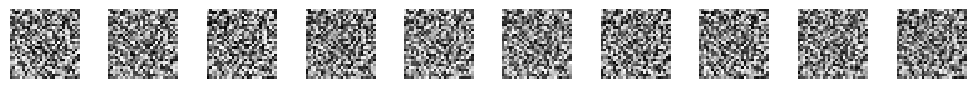

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Generator
def build_generator(latent_dim):
    model = keras.Sequential([
        layers.Dense(128, input_dim=latent_dim),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(784, activation='tanh'),  # 28*28=784 for MNIST images
        layers.Reshape((28, 28))
    ])
    return model

# Discriminator
def build_discriminator():
    model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = keras.Sequential([
        generator,
        discriminator
    ])
    return model

# Load MNIST data
(x_train, _), (_, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0

# GAN setup
latent_dim = 64
generator = build_generator(latent_dim)
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Compile the discriminator (separately)
discriminator.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Compile the GAN
gan.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Training loop
epochs = 50
batch_size = 64
steps_per_epoch = batch_size

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        # Sample random points in the latent space
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # Decode them to fake images
        generated_images = generator.predict(random_latent_vectors)

        # Combine them with real images
        real_images = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        combined_images = np.concatenate([generated_images, real_images])

        # Assemble labels discriminating real from fake images
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        # Add random noise to the labels - important trick!
        labels += 0.05 * np.random.random(labels.shape)

        # Train the discriminator
        d_loss = discriminator.train_on_batch(combined_images, labels)

        # Sample random points in the latent space
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # Assemble labels that say "all real images"
        misleading_targets = np.zeros((batch_size, 1))

        # Train the generator (via the GAN model, where the discriminator weights are frozen)
        a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

    print(f'Epoch {epoch+1}/{epochs}, Discriminator Loss: {d_loss}, Generator Loss: {a_loss}')

# Generating and saving images
import matplotlib.pyplot as plt

def plot_generated_images(generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_generated_images(generator)


In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Initialize the tokenizer from Hugging Face Transformers library
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained('cssupport/t5-small-awesome-text-to-sql')
model = model.to(device)
model.eval()

def generate_sql(input_prompt):
    # Tokenize the input prompt
    inputs = tokenizer(input_prompt, padding=True, truncation=True, return_tensors="pt").to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=512)

    # Decode the output IDs to a string (SQL query in this case)
    generated_sql = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_sql

# Test the function
#input_prompt = "tables:\n" + "CREATE TABLE Catalogs (date_of_latest_revision VARCHAR)" + "\n" +"query for: Find the dates on which more than one revisions were made."
#input_prompt = "tables:\n" + "CREATE TABLE table_22767 ( \"Year\" real, \"World\" real, \"Asia\" text, \"Africa\" text, \"Europe\" text, \"Latin America/Caribbean\" text, \"Northern America\" text, \"Oceania\" text )" + "\n" +"query for:what will the population of Asia be when Latin America/Caribbean is 783 (7.5%)?."
#input_prompt = "tables:\n" + "CREATE TABLE procedures ( subject_id text, hadm_id text, icd9_code text, short_title text, long_title text ) CREATE TABLE diagnoses ( subject_id text, hadm_id text, icd9_code text, short_title text, long_title text ) CREATE TABLE lab ( subject_id text, hadm_id text, itemid text, charttime text, flag text, value_unit text, label text, fluid text ) CREATE TABLE demographic ( subject_id text, hadm_id text, name text, marital_status text, age text, dob text, gender text, language text, religion text, admission_type text, days_stay text, insurance text, ethnicity text, expire_flag text, admission_location text, discharge_location text, diagnosis text, dod text, dob_year text, dod_year text, admittime text, dischtime text, admityear text ) CREATE TABLE prescriptions ( subject_id text, hadm_id text, icustay_id text, drug_type text, drug text, formulary_drug_cd text, route text, drug_dose text )" + "\n" +"query for:" + "what is the total number of patients who were diagnosed with icd9 code 2254?"
input_prompt = "tables:\n" + "CREATE TABLE student_course_attendance (student_id VARCHAR); CREATE TABLE students (student_id VARCHAR)" + "\n" + "query for:" + "List the id of students who never attends courses?"

generated_sql = generate_sql(input_prompt)

print(f"The generated SQL query is: {generated_sql}")
#OUTPUT: The generated SQL query is: SELECT student_id FROM students WHERE NOT student_id IN (SELECT student_id FROM student_course_attendance)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

The generated SQL query is: SELECT student_id FROM students WHERE NOT student_id IN (SELECT student_id FROM student_course_attendance)


In [ ]:
input_prompt = "tables:\n" + "CREATE TABLE student_course_attendance (student_id VARCHAR); CREATE TABLE students (student_id VARCHAR)" + "\n" + "query for:" + "List the id of students who never attends courses?"

generated_sql = generate_sql(input_prompt)

print(f"The generated SQL query is: {generated_sql}")
#OUTPUT: The generated SQL query is: SELECT student_id FROM students WHERE NOT student_id IN (SELECT student_id FROM student_course_attendance)

The generated SQL query is: SELECT student_id FROM students WHERE NOT student_id IN (SELECT student_id FROM student_course_attendance)


In [ ]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c390f25ba0d46426d0f51210b8858b8baeb0e30e390fd1c5c6b7a98af08290b1
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

def create_spark_session():
    return SparkSession.builder \
        .appName("CSV to DataFrame") \
        .getOrCreate()


In [ ]:
import csv
def create_table_query(csv_file):
    # Read the first row of the CSV file to get column names
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)

    # Infer column data types based on the first row
    fields = [StructField(field, StringType(), True) for field in header]

    schema = StructType(fields)

    return schema


In [ ]:

def run_sql_query(spark, csv_file, schema,table_name, query):
    try:
        # Load CSV into DataFrame
        df = spark.read.csv(csv_file, header=True, schema=schema)

        # Register the DataFrame as a temporary view
        df.createOrReplaceTempView(table_name)

        # Run SQL-like query
        result = spark.sql(query).collect()

        return result

    except Exception as e:
        return str(e)


In [ ]:

# Predefined function
def create_query(context, question):
    # Dummy function, replace it with the actual implementation
    return f"SELECT * FROM {context} WHERE {question}"

In [ ]:
def convert_structtype_to_create_table(schema, table_name):
    columns = [f"{field.name} {field.dataType.typeName()}" for field in schema.fields]
    create_table_query = f"CREATE TABLE {table_name} ({', '.join(columns)})"
    return create_table_query

In [ ]:
csv_path = "/content/sample_data/california_housing_test.csv"

In [ ]:
# Create DataFrame schema
schema = create_table_query(csv_path)

schema

StructType([StructField('longitude', StringType(), True), StructField('latitude', StringType(), True), StructField('housing_median_age', StringType(), True), StructField('total_rooms', StringType(), True), StructField('total_bedrooms', StringType(), True), StructField('population', StringType(), True), StructField('households', StringType(), True), StructField('median_income', StringType(), True), StructField('median_house_value', StringType(), True)])

In [ ]:
table_name = "users"

In [ ]:
sql_create_table_query = convert_structtype_to_create_table(schema,table_name)

In [ ]:
question = "what is average of population?"

In [ ]:
input = "tables:\n" + sql_create_table_query + "\n" + "query for:" + question

generated_sql = generate_sql(input)

In [ ]:
generated_sql

'SELECT AVG(population) FROM users'

In [ ]:

# Create Spark session
spark = create_spark_session()

# Run SQL-like query
result = run_sql_query(spark, csv_path, schema,table_name,generated_sql)
print(result)


[Row(avg(population)=1402.7986666666666)]
